Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests

API_KEY = 'ei_fc8e4b34770a976eb34d4449fe35de18561d61be5ad968e262f66b6944a26298'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/51151/training/21/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/51151/training/21/y')


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [3]:
X.shape, Y.shape

((1167, 76800), (1167,))

76, 800 = 160 x 160 x 3

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

	 Label Image==>  3


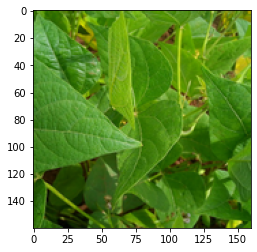

In [6]:
image = X[0]
label = Y[0]
reshape_to = (160,160,3)

print("\t Label Image==> ",label)
img = tf.reshape(image, reshape_to)
plt.imshow(img);

Define our labels and split the data up in a test and training set:

In [7]:
import sys, os, random
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "angular_leaf_spot", "bean_rust", "healthy" ]
classes = len(classes_values)
classes

3

In [8]:
Y

array([3, 3, 3, ..., 1, 1, 1], dtype=int32)

In [9]:
set(Y)

{1, 2, 3}

In [10]:
Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(X_train.shape, Y_test.shape)
print(X_test.shape, Y_test.shape)

(933, 76800) (234, 3)
(234, 76800) (234, 3)


In [11]:
input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Train the model:

In [12]:
import math
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Flatten, Reshape, MaxPooling1D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.losses import categorical_crossentropy

Download the trained model's weigths

In [13]:
WEIGHTS_PATH = './transfer-learning-weights/keras/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_160.h5'
# Download the model weights
root_url = 'http://cdn.edgeimpulse.com/'
p = Path(WEIGHTS_PATH)
if not p.exists():
    if not p.parent.exists():
        p.parent.mkdir(parents=True)
    weights = requests.get(root_url + WEIGHTS_PATH[2:]).content
    with open(WEIGHTS_PATH, 'wb') as f:
        f.write(weights)

In [14]:
p

PosixPath('transfer-learning-weights/keras/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_0.35_160.h5')

In [15]:
INPUT_SHAPE = (160, 160, 3)

In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = INPUT_SHAPE, alpha=0.35,
    weights = WEIGHTS_PATH
)
base_model.trainable = False

In [17]:
model = Sequential()
model.add(InputLayer(input_shape=INPUT_SHAPE, name='x_input'))

# Don't include the base model's top layers
last_layer_index = -3

model.add(Model(inputs=base_model.inputs, outputs=base_model.layers[last_layer_index].output))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 5, 5, 1280)        410208    
_________________________________________________________________
dense (Dense)                (None, 5, 5, 16)          20496     
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1203      
Total params: 431,907
Trainable params: 21,699
Non-trainable params: 410,208
_________________________________________________________________


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [19]:
# Set the data to the expected input shape
train_dataset = train_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(INPUT_SHAPE), tf.data.experimental.AUTOTUNE)

Data Augmentation

In [20]:
# Implements the data augmentation policy
def augment_image(image, label):
    # Flips the image randomly
    image = tf.image.random_flip_left_right(image)

    # Increase the image size, then randomly crop it down to
    # the original dimensions
    resize_factor = random.uniform(1, 1.2)
    new_height = math.floor(resize_factor * INPUT_SHAPE[0])
    new_width = math.floor(resize_factor * INPUT_SHAPE[1])
    image = tf.image.resize_with_crop_or_pad(image, new_height, new_width)
    image = tf.image.random_crop(image, size=INPUT_SHAPE)

    # Vary the brightness of the image
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image, label

In [21]:
train_dataset = train_dataset.map(augment_image, tf.data.experimental.AUTOTUNE)

Train model

In [22]:
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=20, 
    verbose=2, 
    callbacks=callbacks
    )

print('')
print('Initial training done.', flush=True)

Epoch 1/20
30/30 - 11s - loss: 1.0230 - accuracy: 0.5273 - val_loss: 0.7180 - val_accuracy: 0.6368
Epoch 2/20
30/30 - 7s - loss: 0.6935 - accuracy: 0.6977 - val_loss: 0.5933 - val_accuracy: 0.7308
Epoch 3/20
30/30 - 7s - loss: 0.5418 - accuracy: 0.7792 - val_loss: 0.5306 - val_accuracy: 0.7863
Epoch 4/20
30/30 - 7s - loss: 0.4346 - accuracy: 0.8135 - val_loss: 0.4881 - val_accuracy: 0.8077
Epoch 5/20
30/30 - 7s - loss: 0.3638 - accuracy: 0.8639 - val_loss: 0.4766 - val_accuracy: 0.7991
Epoch 6/20
30/30 - 7s - loss: 0.3129 - accuracy: 0.8746 - val_loss: 0.4734 - val_accuracy: 0.8205
Epoch 7/20
30/30 - 7s - loss: 0.2682 - accuracy: 0.8939 - val_loss: 0.4578 - val_accuracy: 0.8205
Epoch 8/20
30/30 - 7s - loss: 0.2395 - accuracy: 0.9057 - val_loss: 0.4244 - val_accuracy: 0.8291
Epoch 9/20
30/30 - 7s - loss: 0.1968 - accuracy: 0.9293 - val_loss: 0.3957 - val_accuracy: 0.8462
Epoch 10/20
30/30 - 7s - loss: 0.1568 - accuracy: 0.9400 - val_loss: 0.3731 - val_accuracy: 0.8547
Epoch 11/20
30/30 

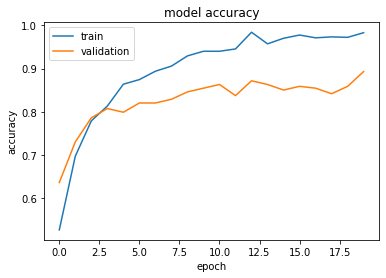

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [24]:
# How many epochs we will fine tune the model
FINE_TUNE_EPOCHS = 10
# What percentage of the base model's layers we will fine tune
FINE_TUNE_PERCENTAGE = 65

print('Fine-tuning model for {} epochs...'.format(FINE_TUNE_EPOCHS), flush=True)

# Determine which layer to begin fine tuning at
model_layer_count = len(model.layers)
fine_tune_from = math.ceil(model_layer_count * ((100 - FINE_TUNE_PERCENTAGE) / 100))

# Allow the entire base model to be trained
model.trainable = True
# Freeze all the layers before the 'fine_tune_from' layer
for layer in model.layers[:fine_tune_from]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000045),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_dataset,
                epochs=FINE_TUNE_EPOCHS,
                verbose=2,
                validation_data=validation_dataset,
                callbacks=callbacks)


Fine-tuning model for 10 epochs...
Epoch 1/10
30/30 - 10s - loss: 0.0470 - accuracy: 0.9893 - val_loss: 0.3541 - val_accuracy: 0.8932
Epoch 2/10
30/30 - 7s - loss: 0.0413 - accuracy: 0.9904 - val_loss: 0.3523 - val_accuracy: 0.9017
Epoch 3/10
30/30 - 7s - loss: 0.0389 - accuracy: 0.9936 - val_loss: 0.3518 - val_accuracy: 0.8974
Epoch 4/10
30/30 - 7s - loss: 0.0505 - accuracy: 0.9861 - val_loss: 0.3511 - val_accuracy: 0.8974
Epoch 5/10
30/30 - 7s - loss: 0.0481 - accuracy: 0.9861 - val_loss: 0.3509 - val_accuracy: 0.9060
Epoch 6/10
30/30 - 7s - loss: 0.0615 - accuracy: 0.9871 - val_loss: 0.3506 - val_accuracy: 0.9060
Epoch 7/10
30/30 - 7s - loss: 0.0471 - accuracy: 0.9904 - val_loss: 0.3513 - val_accuracy: 0.9060
Epoch 8/10
30/30 - 7s - loss: 0.0438 - accuracy: 0.9893 - val_loss: 0.3513 - val_accuracy: 0.9060
Epoch 9/10
30/30 - 7s - loss: 0.0511 - accuracy: 0.9893 - val_loss: 0.3514 - val_accuracy: 0.9060
Epoch 10/10
30/30 - 7s - loss: 0.0543 - accuracy: 0.9893 - val_loss: 0.3510 - val_

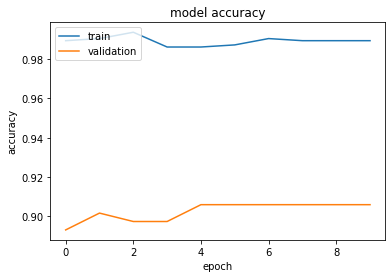

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model to disk
model.save('saved_model')